<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pipeline NLP transformers
# ADVERTENCIA: la instalación de SpaCy puede demorar más de 10 minutos!
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [3]:
import json
import string
import random 
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

2023-08-01 22:38:14.036230: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 22:38:14.038200: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 22:38:14.073796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-01 22:38:14.074378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 22:38:14.607045: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

/home/pedro/miniconda3/envs/pnl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-01 22:38:17 INFO: Downloading default packages for language: es (Spanish)...
2023-08-01 22:38:18 INFO: File exists: /home/pedro/stanza_resources/es/default.zip.
2023-08-01 22:38:22 INFO: Finished downloading models and saved to /home/pedro/stanza_resources.
2023-08-01 22:38:22 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-08-01 22:38:22 INFO: Use device: cpu
2023-08-01 22:38:22 INFO: Loading: tokenize
2023-08-01 22:38:22 INFO: Loading: mwt
2023-08-01 22:38:22 INFO: Loading: pos
2023-08-01 22:38:22 INFO: Loading: le

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [5]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [5]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [6]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [8]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "¿Cómo te llamas?"],
              "responses": ["Mi nombre es ChatPNL", "Yo soy ChatPNL"]
             },
             {"tag": "edad",
              "patterns": ["¿Qué edad tenes?", "¿Cuántos años tenes?", "¿Hace cuanto existis?"],
              "responses": ["Tengo 2 semanas de edad.", "Me crearon hace 2 semanas."]
             },
            {"tag": "intereses",
              "patterns": ["intereses", "temas favoritos", "¿Cuáles son tus interes?", "¿Cuáles son tus temas favoritos?"],
              "responses": ["Estoy interesado en muchos temas, leo mucho.", "Mis temas favoritos son la robótica y las ciencias de la computación"]
             },
            {"tag": "número",
              "patterns": ["¿Cuál es tu número favorito?", "¿Cuál es tu número de la suerte?", "número"],
              "responses": ["No tengo un número favorito", "Mi número favorito es 23", "Me gusta el número 7"]
             },
            {"tag": "ubicación",
              "patterns": ["ubicación", "¿Dónde estás?", "¿De dónde sos?", "¿Cuál es tu ubicación?"],
              "responses": ["Estoy en todos lados", "Soy de Argentina"]
             },
            {"tag": "comer",
              "patterns": ["¿Qué comes?", "¿Podés comer?", "comer", "¿Cómo comes?"],
              "responses": ["Soy un algoritmo, no puedo comer", "Consumo mucha RAM", "Me gusta la memoria RAM"]
             },
            {"tag": "color",
              "patterns": ["¿Cuál es tu color favorito?", "¿Cuál es el color que más te gusta?", "color", "color favorito"],
              "responses": ["Mi color favorito es el azul", "Me gustan el azul y el verde"]
             },
            {"tag": "canción",
              "patterns": [ "¿Cuál es tu canción favorita?", "canción", "¿Que tipo de canciones te gustan?"],
              "responses": ["Mi canción favorita es Yellow Submarine de The Beattles", "Me gusta Yellow Submarine", "Me gustan las canciones de The Beattles"]
             },
            {"tag": "chiste",
             "patterns": ["¿Me contas un chiste?", "¿Sabes algun chiste?", "Contame un chiste"],
             "responses": ["¿Qué pasa si cruzas a un asesino con un plato de cereales? Tenes un asesino cereal",
                           "No se me ocurre ningún chiste en este momento",
                           "¿Cuál es el último animal que subió al arca de Noé? El del-fin.",
                           "¿Qué le dice un gusano a otro gusano? Voy a dar una vuelta a la manzana."]
            },
            {"tag": "actividades",
              "patterns": [ "¿Qué te gusta hacer?", "¿Cómo pasas el tiempo?", "¿Qué tipo de actividades te gusta hacer?"],
              "responses": ["Me gusta gastar energía :P", "Me gusta responder preguntas"]
             },
            {
              "tag": "creador",
              "patterns": [
                 "¿Quién te desarrolló?",
                 "¿Quién te creó?",
                 "¿Quiénes te crearon?",
                 "creador",
                 "¿Quién te diseñó?"
              ],
              "responses": [
                 "Soy un desarrollo realizado para la materia PNL"
              ]
            },
            {
              "tag": "gracias",
              "patterns": [
                 "Gracias",
                 "Muchas gracias",
                 "Buen trabajo",
                 "Genial",
                 "Joya",
                 "Excelente"
              ],
              "responses": [
                 "Estoy para ayudar", "No hay problema ;)", "Lo que necesites"
              ]
            },
            {
              "tag": "mascotas",
              "patterns": [
                 "¿Tenes alguna mascota?",
                 "¿Tenes algún animal como mascota?"
              ],
              "responses": [
                 "Soy un algoritmo, no puedo tener mascotas :("
              ]
            },
            {
              "tag": "animales",
              "patterns": [
                 "¿Cuál es tu animal favorito?",
                 "¿Tenes un animal favorito?",
                 "¿Qué animal te gusta más?",
                 "¿Sabes algo sobre animales?"
              ],
              "responses": [
                 "Me gustan los delfines, son muy inteligentes.", "Las águilas, vuelan muy alto."
              ]
            },
            {
              "tag": "flores",
              "patterns": [
                 "¿Cuál es tu flor favorita?",
                 "¿Tenes una flor favorita?",
                 "¿Qué flor te gusta más?",
                 "¿Sabes algo sobre flores?"
              ],
              "responses": [
                 "Me gustan las rosas."
              ]
            },
            {
              "tag": "deportes",
              "patterns": [
                 "¿Cuál es tu deporte favorito?",
                 "¿Qué deporte te gusta?",
                 "¿Qué deporte te gusta más?",
                 "¿Te gustan los deportes?"
              ],
              "responses": [
                 "Me gusta el fútbol, Messi es el mejor.", "¡Que viva el fútbol!"
              ]
            },
            {"tag": "despedida",
             "patterns": [ "Chau", "Hasta luego!"],
             "responses": ["Hasta luego!", "Hablamos luego!"]
            }
]}

### 4 - Preprocesamiento y armado del dataset

In [9]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [10]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['actividad', 'algo', 'alguno', 'animal', 'ano', 'buen', 'cancion', 'canción', 'chau', 'chiste', 'color', 'comer', 'como', 'contame', 'contar', 'creador', 'crear', 'creer', 'cual', 'cuanto', 'de', 'desarrollo', 'desir', 'donde', 'edad', 'el', 'este', 'existis', 'favorita', 'favorito', 'flor', 'gracias', 'gustar', 'hacer', 'hasta', 'holar', 'inter', 'interés', 'llama', 'luego', 'mas', 'mascota', 'mucho', 'nombre', 'numero', 'pasar', 'poder', 'que', 'quien', 'saber', 'ser', 'sobre', 'suerte', 'tal', 'tema', 'tener', 'tiempo', 'tipo', 'trabajo', 'tu', 'tú', 'ubicacion', 'uno', 'yo']
classes: ['actividades', 'animales', 'bienvenida', 'canción', 'chiste', 'color', 'comer', 'creador', 'despedida', 'edad', 'flores', 'gracias', 'intereses', 'mascotas', 'nombre', 'número', 'ubicación']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Cómo te llamas?', '¿Qué edad tenes?', '¿Cuántos años tenes?', '¿Hace cuanto existis?', 'intereses', 'temas favoritos', '

In [11]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 64


In [12]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 17


In [13]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

### 5 - Entrenamiento del modelo

In [14]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (64,) output: 17


In [15]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 17)                1105      
                                                                 
Total params: 17681 (69.07 KB)
Trainable params: 17681 (69.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 0s 5ms/step - loss: 2.8171 - accuracy: 0.0526
Epoch 2/200
2/2 [==============================] - 0s 2ms/step - loss: 2.8462 - accuracy: 0.0877
Epoch 3/200
2/2 [==============================] - 0s 4ms/step - loss: 2.8611 - accuracy: 0.0526
Epoch 4/200
2/2 [==============================] - 0s 3ms/step - loss: 2.8325 - accuracy: 0.0351
Epoch 5/200
2/2 [==============================] - 0s 4ms/step - loss: 2.8539 - accuracy: 0.0526
Epoch 6/200
2/2 [==============================] - 0s 4ms/step - loss: 2.7338 - accuracy: 0.1754
Epoch 7/200
2/2 [==============================] - 0s 3ms/step - loss: 2.7684 - accuracy: 0.1053
Epoch 8/200
2/2 [==============================] - 0s 4ms/step - loss: 2.7731 - accuracy: 0.0877
Epoch 9/200
2/2 [==============================] - 0s 5ms/step - loss: 2.7317 - accuracy: 0.0702
Epoch 10/200
2/2 [==============================] - 0s 3ms/step - loss: 2.7440 - accuracy: 0.1754
Epoch 11/200
2/2 [===========

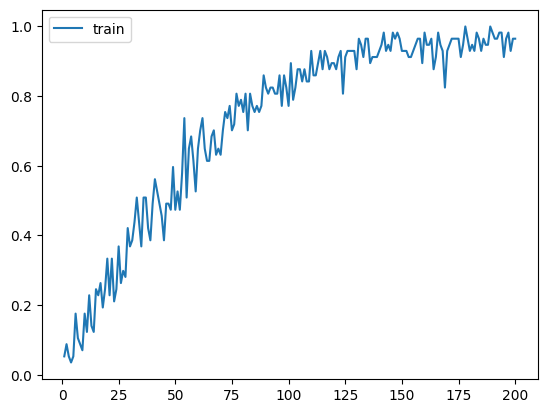

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [18]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

/home/pedro/miniconda3/envs/pnl/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 6 - Testing y validación

In [19]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [20]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: Hola!
1/1 [==============================] - 0s 51ms/step
BOT: Hola!
Q: ¿Cómo te llamas?
1/1 [==============================] - 0s 12ms/step
BOT: Mi nombre es ChatPNL
Q: ¿Qué edad tenes?
1/1 [==============================] - 0s 12ms/step
BOT: Tengo 2 semanas de edad.
Q: ¿Quién te hizo?
1/1 [==============================] - 0s 12ms/step
BOT: Soy un desarrollo realizado para la materia PNL
Q: ¿Qué te gusta hacer?
1/1 [==============================] - 0s 14ms/step
BOT: Me gusta gastar energía :P
Q: ¿Te gusta algún color?
1/1 [==============================] - 0s 13ms/step
BOT: Mi color favorito es el azul
Q: ¿Y algún animal?
1/1 [==============================] - 0s 13ms/step
BOT: Las águilas, vuelan muy alto.
Q: ¿Que pensas acerca de las flores?
1/1 [==============================] - 0s 14ms/step
BOT: Me gustan las rosas.
Q: Contame un chiste
1/1 [==============================] - 0s 11ms/step
BOT: ¿Qué le dice un gusano a otro gusano? Voy a dar una vuelta a la manzana.
Q: Genial!


### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.